In [4]:

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import numpy as np

In [5]:

Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source" # Select early Data Release 3
Gaia.ROW_LIMIT=-1


## We first are going to introduce the DAML catalogue for clusters. The goal will be to create an algorithm which can find the cluster and then assign stars in the region to that cluster. A similar idea is employed in https://www.aanda.org/articles/aa/pdf/2002/27/aa2476.pdf

In [6]:
from astroquery.vizier import Vizier
#Vizier.ROW_LIMIT = -1


In [7]:
catalog_list=Vizier.find_catalogs('Dias+ 2002-2015')


#This is the DAML globular cluster catalogue 
#The warnings need to be dealt with

In [8]:
#An import of all their values
catalogs = Vizier.get_catalogs(catalog_list.values())

# Catalogs has load of different tables, the second one is the list of clusters

In [9]:
cluster_list=catalogs[1] #only has 50 rows

In [10]:
sorted_cluster_list=cluster_list[np.argsort(cluster_list['Dist'])]

sorted_cluster_list

P,Cluster,RAJ2000,DEJ2000,Class,Diam,Dist,E_B-V_,Age,pmRA,pmDE,Nc,K14,RV,o_RV,__Fe_H_,o__Fe_H_,TrType,WEBDA,Lynga
,,"""h:m:s""","""d:m:s""",,arcmin,pc,mag,[yr],mas / yr,mas / yr,,,km / s,,Sun,,,,
str1,str17,str8,str9,str2,float32,int16,float32,float32,float32,float32,int16,str3,float32,int16,float32,int16,str8,str5,str5
P,Blanco 1,00 04 07,-29 50 00,,70.0,269,0.010,7.796,20.17,3.00,27,K14,5.53,49,0.040,8,,WEBDA,Lynga
,Alessi 20,00 10 34,+58 45 36,e,40.0,600,0.220,6.480,8.73,-3.11,17,K14,-11.50,1,--,--,,WEBDA,Lynga
,NGC 7826,00 05 17,-20 41 30,r,20.0,620,0.030,9.340,6.48,-6.20,39,K14,-4.62,1,--,--,4-2-p-*,WEBDA,Lynga
P,NGC 133,00 31 19,+63 21 00,,7.0,630,0.600,7.000,-0.70,-0.40,8,K14,--,--,--,--,4-1-p-*,WEBDA,Lynga
P,NGC 225,00 43 39,+61 46 30,,12.0,657,0.274,8.114,-1.23,-0.06,89,K14,-28.00,1,--,--,,WEBDA,Lynga
,NGC 189,00 39 35,+61 05 42,,5.0,752,0.420,7.000,-0.36,-3.02,80,K14,--,--,--,--,,WEBDA,Lynga
,Berkeley 59,00 02 14,+67 25 00,,10.0,1000,1.241,6.100,-2.11,-1.20,2,K14,-5.17,3,--,--,3-3-m-n,WEBDA,Lynga
,King 1,00 22 04,+64 22 50,d,24.6,1080,0.760,9.600,-2.43,1.02,700,K14,-38.40,10,-0.010,10,2-2-r-*,WEBDA,Lynga


# There will be error on our measurements of the distance to our stars, reference Bailey Jones, so we want to order the clusters by the nearest ones
# We can look at the paper Dias for error on the distance measuremenet about the cluster, must be some error involved

The closest ones of course will have the smallest error when relating to Bailer Jones parallax inversion,
without doing anything rigarous we will take the closest star cluster and look at gaia data just by inverting the parallax to get
a measurement. We will take a window of twice the diameter, and depth twice the diameter.


In [11]:
#Taking the closest cluster
closest_cluster=sorted_cluster_list[0]
closest_cluster



P,Cluster,RAJ2000,DEJ2000,Class,Diam,Dist,E_B-V_,Age,pmRA,pmDE,Nc,K14,RV,o_RV,__Fe_H_,o__Fe_H_,TrType,WEBDA,Lynga
,,"""h:m:s""","""d:m:s""",,arcmin,pc,mag,[yr],mas / yr,mas / yr,,,km / s,,Sun,,,,
str1,str17,str8,str9,str2,float32,int16,float32,float32,float32,float32,int16,str3,float32,int16,float32,int16,str8,str5,str5
P,Blanco 1,00 04 07,-29 50 00,,70.0,269,0.010,7.796,20.17,3.00,27,K14,5.53,49,0.040,8,,WEBDA,Lynga


So we can see there is a diameter of 70.0 arcseconds, we will use a window of size 140.0 arcseconds.
We have a distance measurement of 269pc. We need to get distance estimates of the Gaia Data in that region

Next we are going to call in the GAIA data centered around the catalogued open cluster

In [12]:
#Looking at the cone around the point
right_as_center=closest_cluster['RAJ2000']
dec_center=closest_cluster['DEJ2000']
diam=closest_cluster['Diam']

#is the frame right
coord = SkyCoord(right_as_center,dec_center, unit=(u.hourangle, u.deg))
rad = u.Quantity(diam, u.arcminute)

r = Gaia.cone_search_async(coordinate=coord, radius=rad, verbose=True)
gaia_edr3=r.get_results()

Launched query: '
                SELECT
                  
                  *,
                  DISTANCE(
                    POINT('ICRS', ra, dec),
                    POINT('ICRS', 1.0291698321917175, -29.833330905250314)
                  ) AS dist
                FROM
                  gaiaedr3.gaia_source
                WHERE
                  1 = CONTAINS(
                    POINT('ICRS', ra, dec),
                    CIRCLE('ICRS', 1.0291698321917175, -29.833330905250314, 1.1666666666666667)
                  )
                ORDER BY
                  dist ASC
                '
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Sat, 04 Dec 2021 09:36:26 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=blo

In [13]:
#Print the table
gaia_edr3


solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg,
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 2320827909591325056,2320827909591325056,1592198863,2016.0,1.015981930167069,0.49987766,-29.824162726631137,0.41829798,-2.0865498538758396,0.5794813,-3.60072,0.44665593,-0.06717043567684688,0.60586464,0.44157633587533707,0.4926354,-0.10760638,0.36690092,0.50589794,-0.16185193,-0.3117634,-0.04303693,0.5220674,-0.07245915,-0.28661653,0.0006765611,280,0,278,2,0.088630415,292.29675,0.0,0.0,31,False,1.566035,--,--,--,--,--,--,--,33,18,0.887862,38,7,0,0.021938711,74.08484,0,0,1.0025731,0.28142568,0.20073365,0.10364383,0.7032929,-41.511887,-1.5073847,31.989674,14.577966,False,320,193.81962739049592,1.1130284,174.13718,19.968872,32,131.08735452588292,11.087876,11.822584,20.04464,31,121.73481299366311,6.5201693,18.6705,19.534359,0,0,0,0,0,1.3044199,0.5102806,0.07576752,0.4345131,--,--,0,--,--,--,15.632446089530552,-79.25182926532618,348.0416582704387,-27.543343853338374,0.01466101910210699
1636042515805110273,Gaia EDR3 2320827879527299328,2320827879527299328,491857494,2016.0,1.049900291744989,3.6796942,-29.825765274127917,4.589537,--,--,--,--,--,--,--,--,-0.73318756,--,--,--,-

Right so we have loads of error stuff here and there is going to be a lot of management of that.
Can we trust the distance estimates on this.

Either way we need to figure out the depth of this. How many we are going to accept.

Now we are going to do Bailer Jones data

In [14]:
Vizier.ROW_LIMIT = -1
bailer = Vizier.query_region(coord,
                                 radius=rad,
                                 catalog='I/352/gedr3dis')

In [15]:
bjones=bailer[0]
bjones


Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag
,deg,deg,pc,pc,pc,pc,pc,pc,
int64,float64,float64,float64,float64,float64,float64,float64,float64,int32
2314546502741963904,0.96583661444,-30.99691720017,1894.10693000,1039.53943000,2835.88501000,3324.18384000,2762.83496000,3996.71777000,10033
2314546369597053696,0.99846703055,-30.98905473164,2219.46777000,1100.83350000,4682.46582000,857.79760700,715.87896700,1050.30249000,11033
2314546575755789056,0.95254011615,-30.98595207167,1306.44214000,771.99603300,2271.42285000,9738.49805000,8234.71582000,12241.02050000,20033
2314546708900403584,0.96710571964,-30.96621414806,1341.11975000,896.87835700,1917.54175000,1450.77966000,1067.83240000,1730.60181000,10033
2314546708900404352,0.97448703956,-30.96359882823,943.89025900,529.88793900,1755.20789000,15650.70410000,13054.46680000,19768.20700000,20033
2314546708900405888,0.96435353716,-30.95882424959,3412.70117000,2345.08203000,6707.69531000,6478.59277000,5281.82227000,8211.66797000,10033
2314548843498958976,0.80183494480,-30.97489751775,732.54840100,692.12103300,781.52258300,726.00061000,678.48059100,766.12420700,10033
2314548877858696960,0.78513614988,-30.97797343225,1382.96277000,1211.61682000,1550.66882000,1369.74341000,1241.45264000,1537.38184000,10033


In [16]:
#see how many matches we have
count=0
for i in range (0, len(gaia_edr3['source_id'])):

    if(gaia_edr3['source_id'][i] not in bjones['Source']):
        count+=1
count
count + len(bjones['Source'])-len(gaia_edr3['source_id'])

0

Okay this gives all of the data that has Bailer jones distance estimates

In [17]:
bailer[0].columns

<TableColumns names=('Source','RA_ICRS','DE_ICRS','rgeo','b_rgeo','B_rgeo','rpgeo','b_rpgeo','B_rpgeo','Flag')>

In [18]:
gaia_edr3=gaia_edr3[gaia_edr3['parallax']>=-1000] #there is probably a better way of getting rid of the zero values but we shouldnt have that

#Now im getting rid of the values with a nonzero parallax


In [19]:
len(gaia_edr3)==len(bjones)

#Great, so it works and now we have catalogues with the same values

True

# Now we need to add on the columns and merge them together, we order them by source code, that should maek it easier.



In [20]:
gaia_edr3=gaia_edr3[np.argsort(gaia_edr3['source_id'])]
bjones=bjones[np.argsort(bjones['Source'])]

In [21]:
False in (gaia_edr3['source_id']==bjones['Source'])

#these dataframes are weird but basically theyre the same
#moreover i think i shoud have a pipline of changing these to more readable stuff lol
 

False

# I will of course tidy up my code more before this but we are just doing it now this way

In [22]:
import pandas as pd
gaia_edr3=gaia_edr3.to_pandas()
bjones=bjones.to_pandas()

#However information about the units has been lost entirely here

In [23]:
#The next code is a bit of a ring around btu its going to give us what we want
# We have ordered the dataframes by increasing source id so that we shoudl have right sources

total_gaia = pd.concat([gaia_edr3,bjones], axis=1, join="inner")
total_gaia

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag
0,1636042515805110273,Gaia EDR3 2314546369597053696,2314546369597053696,586187258,2016.0,0.998467,0.720340,-30.989055,0.581206,0.557941,...,2314546369597053696,0.998467,-30.989055,2219.467770,1100.833500,4682.465820,857.797607,715.878967,1050.302490,11033
1,1636042515805110273,Gaia EDR3 2314546502741963904,2314546502741963904,1140645822,2016.0,0.965837,0.386703,-30.996917,0.357418,0.529255,...,2314546502741963904,0.965837,-30.996917,1894.106930,1039.539430,2835.885010,3324.183840,2762.834960,3996.717770,10033
2,1636042515805110273,Gaia EDR3 2314546575755789056,2314546575755789056,287050729,2016.0,0.952540,1.288880,-30.985952,0.773806,-0.310702,...,2314546575755789056,0.952540,-30.985952,1306.442140,771.996033,2271.422850,9738.498050,8234.715820,12241.020500,20033
3,1636042515805110273,Gaia EDR3 2314546708900403584,2314546708900403584,1353493370,2016.0,0.967106,0.435415,-30.966214,0.311921,0.713281,...,2314546708900403584,0.967106,-30.966214,1341.119750,896.878357,1917.541750,1450.779660,1067.832400,1730.601810,10033
4,1636042515805110273,Gaia EDR3 2314546708900404352,2314546708900404352,579283399,2016.0,0.974487,1.572234,-30.963599,1.547981,-0.977513,...,2314546708900404352,0.974487,-30.963599,943.890259,529.887939,1755.207890,15650.704100,13054.466800,19768.207000,20033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11264,1636042515805110273,Gaia EDR3 2333079011745422080,2333079011745422080,951317931,2016.0,0.402550,0.281740,-28.829640,0.247408,0.656041,...,2333079011745422080,0.402550,-28.829640,1339.548580,961.965576,1680.022580,1642.938350,1295.826050,1997.715210,10033
11265,1636042515805110273,Gaia EDR3 2333079217904226688,2333079217904226688,1019298986,2016.0,0.407020,1.051209,-28.803642,0.983076,-0.611096,...,2333079217904226688,0.407020,-28.803642,1207.369260,740.129761,1876.978640,1230.417240,1015.634830,1421.428220,10033
11266,1636042515805110273,Gaia EDR3 2333079256559566080,2333079256559566080,897780732,2016.0,0.414769,0.016595,-28.797787,0.013253,4.736512,...,2333079256559566080,0.414769,-28.797787,209.591568,208.819443,210.298141,209.462753,208.755417,210.309189,10033
11267,1636042515805110273,Gaia EDR3 2333079600156949888,2333079600156949888,1060882940,2016.0,0.455047,0.075956,-28.783249,0.063205,1.065554,...,2333079600156949888,0.455047,-28.783249,909.209839,835.969360,1011.696110,930.442810,863.094666,1008.806090,10033


In [24]:
#Now finally lets just make sure again thaat its all matching in the rows
(total_gaia['source_id']==total_gaia['Source']).index[(total_gaia['source_id']==total_gaia['Source'])==False]
#Right so this says it all matches up thats good

Int64Index([], dtype='int64')

# Now we are going to do some of the selection criterion
We have already selected a radius twice the radius of the radius stated of the literature. 
We are going to make certain initial cuts:
1) Parallax cut
2) Magnitude cut
3) Star cut

In [25]:
print('The closest star cluster value is:', closest_cluster['Dist'], 'pc')


The closest star cluster value is: 269 pc


We want to choose sources that given any posterior estimate of their distances including error they are within the desired region. Note we havent used error in the right acention or anything weve calculated so far


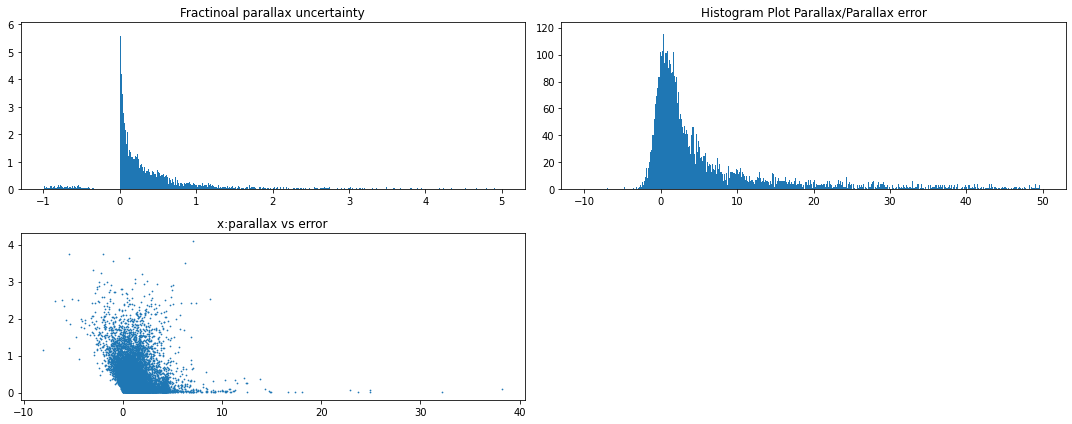

In [26]:
#Let us first plot the parallax vs error
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
ax0=total_gaia['parallax_error']
ax1=total_gaia['parallax']
ax2=total_gaia['parallax_over_error']

fig=plt.figure(figsize=(15,6))
grid=gs.GridSpec(2,2)
a1=plt.subplot(grid[0,0])
a2=plt.subplot(grid[0,1])
a3=plt.subplot(grid[1,0])

a1.hist(1.0/(ax2),density=True,bins=1000,range=[-1,5])
a1.set_title('Fractinoal parallax uncertainty')

a2.hist(ax2,density=False,bins=1000,range=[-10,50])
a2.set_title('Histogram Plot Parallax/Parallax error')

a3.scatter(ax1,ax0,s=0.5)
a3.set_title('x:parallax vs error')

plt.tight_layout()

# We want to now use the Bailer Jones paper to get:
1) A parallax measurement correspondig to the cluster distance using the likelihood fucntion proposed in the paper
2) Use the distance measurements according to him

In [27]:
#The distance measurement to the cluster is
closest_cluster['Dist']
closest_cluster_parallax_est=1.0/closest_cluster['Dist']
closest_cluster_parallax_est

closest_cluster['Dist']

#This is probably too far away. The parallax is tiny


269

In [28]:
#This is very far away, so what we are going to do is cut using the bailer jones
upper_r_bound=closest_cluster['Dist']+closest_cluster['Diam']
lower_r_bound=closest_cluster['Dist']-closest_cluster['Diam']
selection_region=pd.Interval(left=float(lower_r_bound), right=float(upper_r_bound))

First we will get rid of stuff where the digameter values not contained in the percentile region. 

In [29]:
selection_gaia=total_gaia[(total_gaia['b_rgeo'] <= upper_r_bound)]
selection_gaia=selection_gaia[(selection_gaia['B_rgeo'] <= upper_r_bound)]
selection_gaia=selection_gaia[(selection_gaia['b_rgeo'] >= lower_r_bound)]
selection_gaia=selection_gaia[(selection_gaia['B_rgeo'] >= lower_r_bound)]
selection_gaia

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag
53,1636042515805110273,Gaia EDR3 2314560521515227008,2314560521515227008,1188205953,2016.0,0.758284,0.090812,-30.970927,0.062548,3.369276,...,2314560521515227008,0.758284,-30.970927,293.414612,284.736786,301.814362,293.492859,283.403503,303.228821,10033
110,1636042515805110273,Gaia EDR3 2314563957489099392,2314563957489099392,143446320,2016.0,0.821355,0.313571,-30.822690,0.254544,4.421485,...,2314563957489099392,0.821355,-30.822690,233.656235,216.609177,259.749939,282.592682,268.253693,307.851654,10033
115,1636042515805110273,Gaia EDR3 2314564236661739776,2314564236661739776,1674022600,2016.0,0.795322,0.190790,-30.798013,0.149252,3.419322,...,2314564236661739776,0.795322,-30.798013,292.776642,275.917603,317.597107,305.065430,286.212097,326.901581,10033
121,1636042515805110273,Gaia EDR3 2314564683338339328,2314564683338339328,398918923,2016.0,0.578917,0.018264,-30.905167,0.015067,3.344654,...,2314564683338339328,0.578917,-30.905167,295.401733,293.391846,297.437958,295.306610,293.521851,296.984772,10033
137,1636042515805110273,Gaia EDR3 2314565542331796992,2314565542331796992,660311805,2016.0,0.571160,0.038724,-30.876648,0.031333,4.225443,...,2314565542331796992,0.571160,-30.876648,233.976562,231.232208,237.429611,233.775284,231.000015,236.547546,10033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11194,1636042515805110273,Gaia EDR3 2333059156112687232,2333059156112687232,629660289,2016.0,0.909224,0.015233,-28.696464,0.010802,4.188592,...,2333059156112687232,0.909224,-28.696464,236.338928,235.518234,237.217575,236.398956,235.509628,237.259216,10033
11197,1636042515805110273,Gaia EDR3 2333059289255651456,2333059289255651456,162584692,2016.0,0.826536,0.152771,-28.733230,0.127221,3.877051,...,2333059289255651456,0.826536,-28.733230,257.690399,245.380157,274.592010,274.838989,264.302765,284.717163,10021
11202,1636042515805110273,Gaia EDR3 2333059774587977600,2333059774587977600,99309353,2016.0,0.870024,0.058058,-28.707292,0.043053,3.271097,...,2333059774587977600,0.870024,-28.707292,300.217682,296.225739,305.847931,302.815460,296.925781,308.671417,10033
11227,1636042515805110273,Gaia EDR3 2333076748298666880,2333076748298666880,219924269,2016.0,0.377536,0.017318,-28.866554,0.015475,3.163843,...,2333076748298666880,0.377536,-28.866554,311.812317,309.280853,314.340912,311.789612,309.554535,313.978302,10033


So now we have selected objects such that the BJ percentiles are contained within the region plus or minus twice the epected radius.
Now let us plot and see what our parallax is like



# Plot for selected region

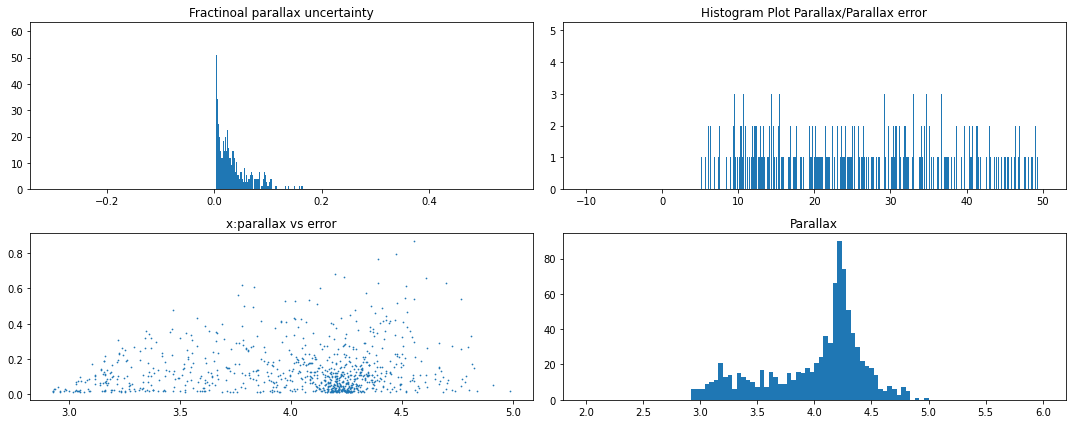

In [30]:
ax0=selection_gaia['parallax_error']
ax1=selection_gaia['parallax']
ax2=selection_gaia['parallax_over_error']

fig=plt.figure(figsize=(15,6))

grid=gs.GridSpec(2,2)

a1=plt.subplot(grid[0,0])
a2=plt.subplot(grid[0,1])
a3=plt.subplot(grid[1,0])
a4=plt.subplot(grid[1,1])

a1.hist(1.0/(ax2),density=True,bins=1000,range=[-0.3,0.55])
a1.set_title('Fractinoal parallax uncertainty')

a2.hist(ax2,density=False,bins=1000,range=[-10,50])
a2.set_title('Histogram Plot Parallax/Parallax error')

a3.scatter(ax1,ax0,s=0.5)
a3.set_title('x:parallax vs error')

a4.hist(ax1,density=False,bins=100,range=[2,6])
a4.set_title('Parallax')

plt.tight_layout()

There is a fairly uniform scatter from parallax uncertainty. Should analyse this a bit more to be honest. I will

We can see there seems to be some sort of peak in the parallax for a lot of the data. Could this correspond to our cluster!

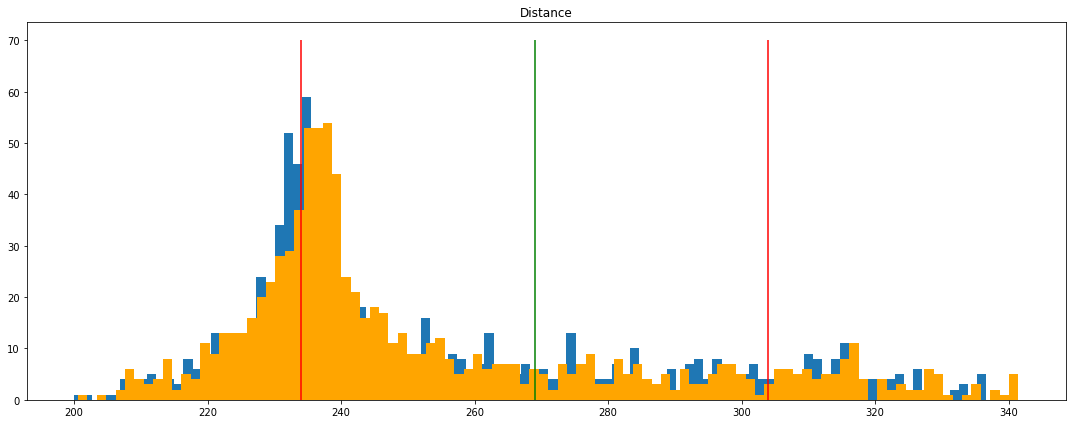

In [31]:
#Lets check with the distance and do a plot that way
fig=plt.figure(figsize=(15,6))

a=plt.subplot()

def para(x):
    return (1.0/x)*1000

ax0=selection_gaia['rgeo'] #median posterior densirty
ax1=selection_gaia['parallax'].apply(para)
a.hist(ax0,density=False,bins=100)
a.hist(ax1,density=False,bins=100,color='orange',)
a.set_title('Distance')

a.vlines(closest_cluster['Dist'],0,70, colors='g')
a.vlines(closest_cluster['Dist']+0.5*closest_cluster['Diam'],0,70, colors='r')
a.vlines(closest_cluster['Dist']-0.5*closest_cluster['Diam'],0,70, colors='r')

plt.tight_layout()



# T he organge above is standard parallax inversion, blue is bailer jones estimates, lines correspond to center and redius

Right so it seems that the majority of the stars are clumped around the distance estimate minus the radius of the literature value.

# We REALLY need to check the errors and analyse the BJ estimtes of distances and everything. So above we have the green line is the center to this star cluster. But all of the values seem to be gathered arouund the red mark. Weird.


Now lets plot the HR diagram and the diagram of kineamtic properties

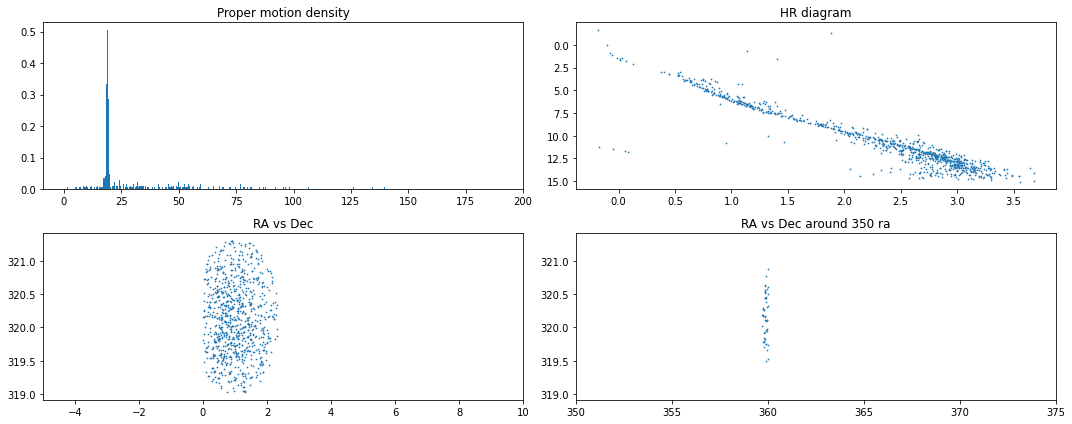

In [32]:
g_band=selection_gaia['phot_bp_mean_mag']-2.5*np.log10((selection_gaia['rgeo']/10.0)**2) #mean absolute magnitude in G band
bp_rp=selection_gaia['bp_rp'] #mean difference

proper_motion=selection_gaia['pm']   #total proper motion

right_asc=selection_gaia['ra']
dec=np.mod(selection_gaia['dec'],350)  #position in motion still with no error bars but i will

ig=plt.figure(figsize=(15,6))

grid=gs.GridSpec(2,2)

a1=plt.subplot(grid[0,0])
a2=plt.subplot(grid[0,1])
a3=plt.subplot(grid[1,0])
a4=plt.subplot(grid[1,1])

a1.hist(proper_motion,density=True,bins=1000)
a1.set_title('Proper motion density')

a2.scatter(bp_rp,g_band,s=0.5)
a2.invert_yaxis()
a2.set_title('HR diagram')

a3.scatter(right_asc,dec,s=0.5)
a3.set_xlim(-5,10)
a3.set_title('RA vs Dec')

a4.scatter(right_asc,dec,s=0.5)
a4.set_xlim(350,375)
a4.set_title('RA vs Dec around 350 ra')

plt.tight_layout()

#can do something with mod or whatever to get the wrap around
# There is a periodic plot or a better way to do this but leave for now

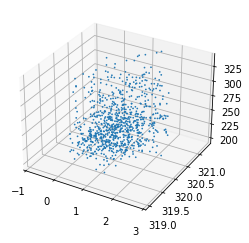

In [33]:




fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-1,3)
ax.scatter(right_asc,dec, selection_gaia['rgeo'], s=0.5 )